# Automatic Differentiation and MCMC

## Introduction

Gaussian Markov Random Fields (GMRFs) are powerful tools for Bayesian inference.
When the parameters of a GMRF model are unknown, we often want to infer them
from observed data. Traditional optimization methods can be limiting, but modern
MCMC methods like NUTS (No-U-Turn Sampler) provide a robust approach for full
Bayesian inference.

Automatic differentiation (AD) is crucial for efficient MCMC sampling, as it
enables gradient-based samplers to explore complex posterior geometries effectively.
This tutorial demonstrates how to leverage AD with GMRFs for Bayesian parameter
inference using NUTS in Turing.jl.

The key to AD support in GaussianMarkovRandomFields.jl is using the
`:autodiffable` solver backend, which uses LDLFactorizations.jl instead
of the default sparse Cholesky factorization. This enables ForwardDiff.jl
to track derivatives through the linear algebra operations.

In [1]:
using LDLFactorizations, Distributions
using GaussianMarkovRandomFields
using Random, LinearAlgebra, SparseArrays
using Plots

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


## MCMC Parameter Inference for CAR Models

We'll demonstrate Bayesian inference for the parameters of a conditional
autoregressive (CAR) model. Given observations from a CAR process, we'll
infer both the spatial correlation parameter (ρ) and variance parameter (σ)
using NUTS sampling.

### Problem setup: CAR model parameter inference

We'll tackle a simple 1D time series problem: given observations sampled
from a conditional autoregressive (CAR) process, infer the CAR parameter (ρ).

In [2]:
using Turing, SparseArrays

Set up a 1D grid (time points)

In [3]:
xs = 0:0.1:2  # 21 time points
N = length(xs)

21

Create adjacency matrix for second-order CAR (neighbors and next-neighbors)

In [4]:
W = spzeros(N, N)
for i = 1:N
    for k in [-2, -1, 1, 2]
        j = i + k
        if 1 <= j <= N
            W[i, j] = 1.0 / abs(k)
        end
    end
end

Generate synthetic observations from true CAR process

In [5]:
Random.seed!(123)
true_ρ = 0.85  # True CAR parameter
true_σ = 0.01  # True field variance
μ = zeros(N)   # Zero mean

21-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Generate true CAR model and sample from it

In [6]:
true_car = generate_car_model(W, true_ρ; μ = μ, σ = true_σ,
                             solver_blueprint=CholeskySolverBlueprint{:autodiffable}())

GMRF{Float64, LinearMaps.WrappedMap{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}, CholeskySolver{:autodiffable, TakahashiStrategy, Float64, LinearMaps.WrappedMap{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}, LDLFactorizations.LDLFactorization{Float64, Int64, Int64, Int64}}}(
mean: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
precision: 21×21 LinearMaps.WrappedMap{Float64} of
  21×21 SparseArrays.SparseMatrixCSC{Float64, Int64} with 99 stored entries
solver: CholeskySolver{:autodiffable, TakahashiStrategy, Float64, LinearMaps.WrappedMap{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}, LDLFactorizations.LDLFactorization{Float64, Int64, Int64, Int64}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 21×21 LinearMaps.WrappedMap{Float64} of
  21×21 SparseArrays.SparseMatrixCSC{Float64, Int64} with 99 stored entries, LDLFactorizations.LDLFactorization{

Our "observations" are just a sample from the true CAR

In [7]:
observations = rand(true_car)

println("Generated observations from CAR process with $(N) time points")
println("True CAR parameter ρ: $(true_ρ)")
println("True variance parameter σ: $(true_σ)")

Generated observations from CAR process with 21 time points
True CAR parameter ρ: 0.85
True variance parameter σ: 0.01


### Bayesian model in Turing

We'll use a simple model:
- x ~ CAR(W, ρ, σ) where ρ and σ are parameters to infer
- ρ ~ Uniform(0.5, 0.99)
- σ ~ Uniform(0.001, 0.1)
- y = x (direct observation of the CAR process)

Again, the crucial bit here is using the `:autodiffable` solver backend.

In [8]:
@model function car_model(y, W, μ)
    # Prior on CAR parameter
    ρ ~ Uniform(0.5, 0.99)

    # Prior on variance parameter
    σ ~ Uniform(0.001, 0.1)

    # CAR process
    car_dist = generate_car_model(W, ρ; μ = μ, σ = σ,
                                 solver_blueprint=CholeskySolverBlueprint{:autodiffable}())

    # Direct observation
    y ~ car_dist
end

car_model (generic function with 2 methods)

Create the model

In [9]:
model = car_model(observations, W, μ)

DynamicPPL.Model{typeof(Main.var"##226".car_model), (:y, :W, :μ), (), (), Tuple{Vector{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(Main.var"##226".car_model, (y = [0.07840387299483453, 0.08930313551294565, 0.0568103036193451, 0.08267097408818341, -0.025373176002426064, -0.0525144955980359, -0.16214702025581984, -0.05502378606163386, -0.051828462039471106, -0.011947395381926016  …  0.016379935558217797, 0.021789192443508, -0.07393817365539637, -0.05328451077296106, -0.020084724732943468, 0.000678582049044622, -0.03016630854446354, -0.08709273978627284, -0.13240380240329042, -0.03370866463496189], W = sparse([2, 3, 1, 3, 4, 1, 2, 4, 5, 2  …  20, 17, 18, 20, 21, 18, 19, 21, 19, 20], [1, 1, 2, 2, 2, 3, 3, 3, 3, 4  …  18, 19, 19, 19, 19, 20, 20, 20, 21, 21], [1.0, 0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5  …  0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 1.0], 21, 21), μ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …

### MCMC Sampling with NUTS

NUTS requires gradients, which are automatically computed via ForwardDiff
thanks to our autodifferentiable GMRF implementation.

In [10]:
println("Starting MCMC sampling...")
Random.seed!(456)

sampler = NUTS()
chain = sample(model, sampler, 1000, progress=false)

println("MCMC sampling completed!")

Starting MCMC sampling...
┌ Info: Found initial step size
└   ϵ = 1.5812500000000003
MCMC sampling completed!


### Analyze results

Extract CAR parameter samples

In [11]:
ρ_samples = chain[:ρ].data[:, 1]
ρ_mean = mean(ρ_samples)
ρ_std = std(ρ_samples)

0.12628870284765983

Extract variance parameter samples

In [12]:
σ_samples = chain[:σ].data[:, 1]
σ_mean = mean(σ_samples)
σ_std = std(σ_samples)

println("Posterior summary for CAR parameter ρ:")
println("True value: $(true_ρ)")
println("Posterior mean: $(round(ρ_mean, digits=4)) ± $(round(ρ_std, digits=4))")
println("95% credible interval: $(round(quantile(ρ_samples, 0.025), digits=4)) - $(round(quantile(ρ_samples, 0.975), digits=4))")

ρ_in_ci = quantile(ρ_samples, 0.025) <= true_ρ <= quantile(ρ_samples, 0.975)
println("True ρ value in 95% CI: $(ρ_in_ci)")

println("\nPosterior summary for variance parameter σ:")
println("True value: $(true_σ)")
println("Posterior mean: $(round(σ_mean, digits=4)) ± $(round(σ_std, digits=4))")
println("95% credible interval: $(round(quantile(σ_samples, 0.025), digits=4)) - $(round(quantile(σ_samples, 0.975), digits=4))")

σ_in_ci = quantile(σ_samples, 0.025) <= true_σ <= quantile(σ_samples, 0.975)
println("True σ value in 95% CI: $(σ_in_ci)")

Posterior summary for CAR parameter ρ:
True value: 0.85
Posterior mean: 0.7714 ± 0.1263
95% credible interval: 0.515 - 0.9665
True ρ value in 95% CI: true

Posterior summary for variance parameter σ:
True value: 0.01
Posterior mean: 0.0097 ± 0.0039
95% credible interval: 0.0044 - 0.0197
True σ value in 95% CI: true


Plot posterior for CAR parameter

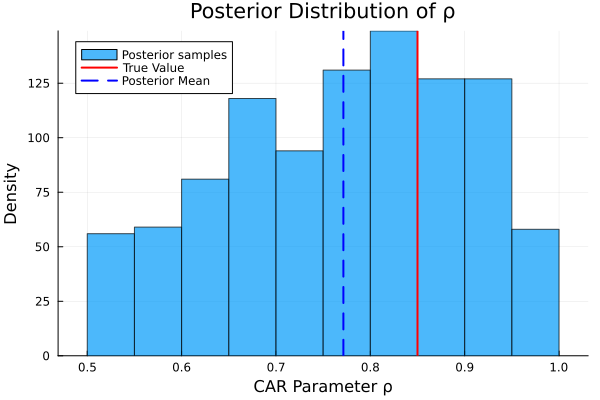

In [13]:
p1 = histogram(ρ_samples, bins=20, alpha=0.7, label="Posterior samples",
               xlabel="CAR Parameter ρ", ylabel="Density",
               title="Posterior Distribution of ρ")
vline!([true_ρ], label="True Value", color=:red, linewidth=2)
vline!([ρ_mean], label="Posterior Mean", color=:blue, linewidth=2, linestyle=:dash)

Plot posterior for variance parameter

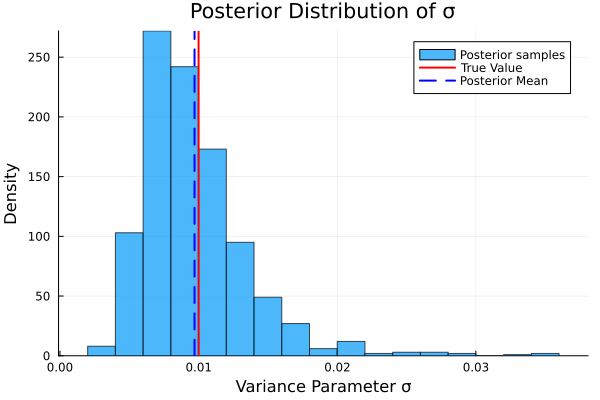

In [14]:
p2 = histogram(σ_samples, bins=20, alpha=0.7, label="Posterior samples",
               xlabel="Variance Parameter σ", ylabel="Density",
               title="Posterior Distribution of σ")
vline!([true_σ], label="True Value", color=:red, linewidth=2)
vline!([σ_mean], label="Posterior Mean", color=:blue, linewidth=2, linestyle=:dash)

Plot trace of CAR parameter

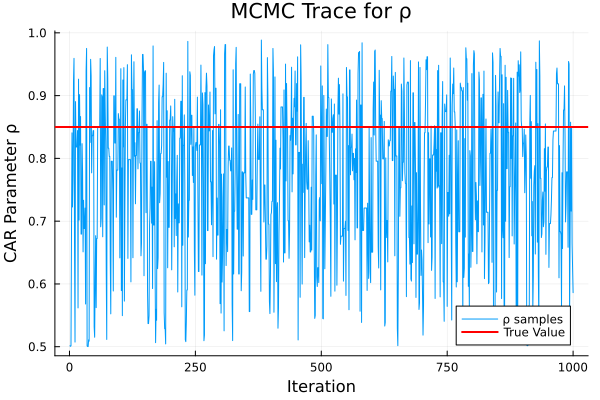

In [15]:
p3 = plot(ρ_samples, label="ρ samples", xlabel="Iteration", ylabel="CAR Parameter ρ",
          title="MCMC Trace for ρ")
hline!([true_ρ], label="True Value", color=:red, linewidth=2)

Plot trace of variance parameter

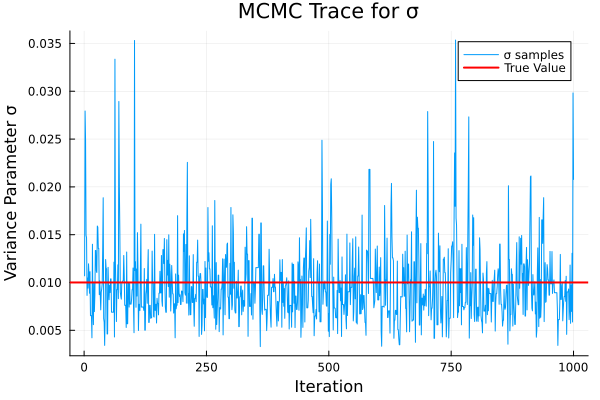

In [16]:
p4 = plot(σ_samples, label="σ samples", xlabel="Iteration", ylabel="Variance Parameter σ",
          title="MCMC Trace for σ")
hline!([true_σ], label="True Value", color=:red, linewidth=2)

Combine plots

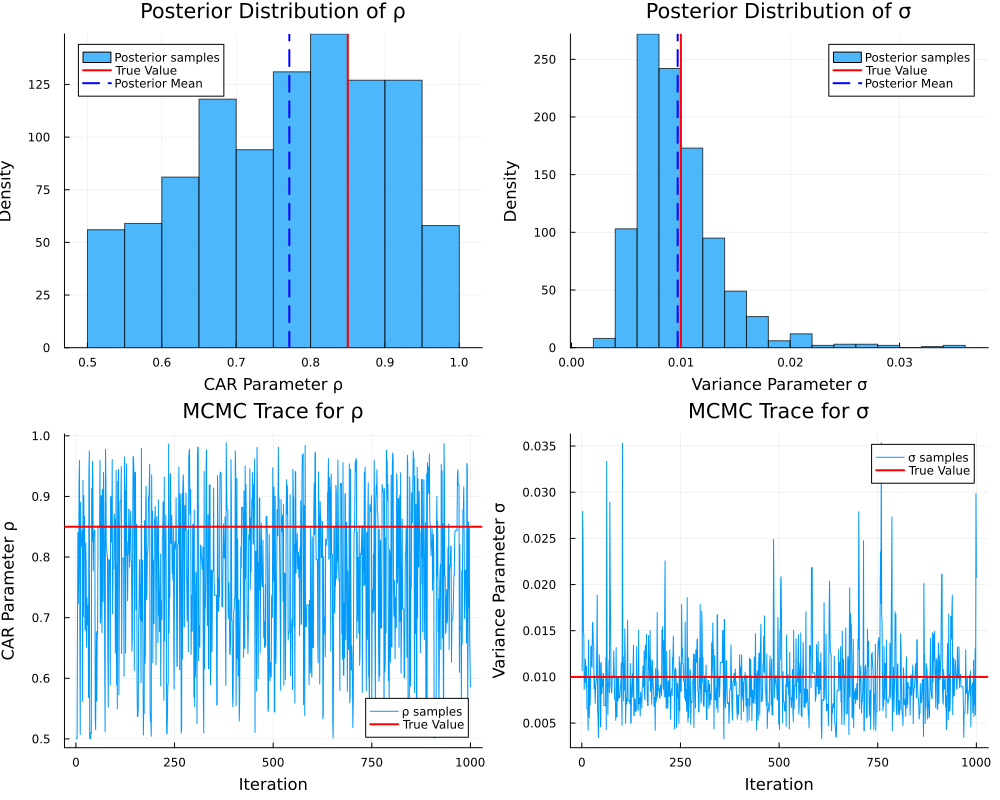

In [17]:
combined_plot = plot(p1, p2, p3, p4, layout=(2,2), size=(1000, 800))

## Conclusion
This tutorial demonstrated how AD enables advanced sampling methods like NUTS
for full Bayesian inference with GMRFs.

In practice, MCMC still quickly becomes prohibitively expensive, so people instead
use Integrated Nested Laplace Approximations (INLA).
More on this soon.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*